In [ ]:
# Importing Libraries

from functions.final_functions import * 

import numpy as np
from spectral import *
from functions.dataset_functions import *
from functions.augmentations import *

import dask.array as da
from dask.distributed import Client
# from sklearn.linear_model import SGDClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.decomposition import IncrementalPCA

In [ ]:
# Initialize Dask client
client = Client()
print(client)

In [ ]:
# Load and preprocess data
output_dir = "Path to Electrolyzers dataset/Electrolyzers-HSI"
HSI, RGB, GT = load_triplets(output_dir)

# Apply vector-wise normalization with mask to all HSIs
normalized_HSI_bandwise = [normalize_hsi_vector_wise_with_mask(hsi, gt) for hsi, gt in zip(HSI, GT)]

# Spectral Binning 360 bands --> 180 bands
HSI = spectral_binning(normalized_HSI_bandwise) # experiement normalized_HSI_bandwise


# Train-test split
train_indices = [2, 3, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 54]
test_indices = [0, 1, 4, 5, 6, 7, 8, 12, 41, 46, 50]

In [ ]:
# Inference 
import joblib
# Data generation and features extraction
test, test_GT, test_rgb = Generate_data(test_indices, normalized_HSI_bandwise, GT, RGB)
test_X, test_y = extract_features_and_labels(test, test_GT, ignore_classes=[0])
chunk_size = 10000
test_X_da = da.from_array(test_X, chunks=(chunk_size, test_X.shape[1]))
test_y_da = da.from_array(test_y, chunks=chunk_size)

# Loading trained SVM model
pipeline = joblib.load('weights/svm_vector_norm.pkl')

# Using Dask Pipeline to perform the predictions
batch_size = 50000
test_predictions = np.concatenate([
    pipeline.predict(test_X_da[i:i+batch_size])  
    for i in range(0, test_X_da.shape[0], batch_size)
])

# Adjust labels if needed (ensure consistency with your dataset)
test_predictions2 = test_predictions - 1
test_y2 = test_y - 1

# Evaluate segmentation metrics
confusion_matrix_sum, true_positive_sum, true_negative_sum, false_positive_sum, false_negative_sum, precision, recall, f1_score, pixel_accuracy_per_class, pixel_accuracy, iou, dice_coefficient, kappa = evaluate_segmentation(test_y2, test_predictions2, 5)


print("F1 Score:", f1_score)
# Alternative evaluation
evaluate_segmentation2(test_y2, test_predictions2, 5)

/opt/conda/lib/python3.8/site-packages/dask/array/core.py:1642: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/dask/array/core.py:1642: FutureWarning: The `numpy.may_share_memory` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


F1 Score: [0.80623868 0.03262715 0.15204797 0.28886909 0.0306745 ]


{'confusion_matrix_sum': array([[34505,   174,    62,  2025,   148],
        [ 3995,   221,   402,  7764,    59],
        [ 5388,    66,  1496,  8873,   200],
        [ 2287,    61,   754,  6972,    75],
        [ 2506,   584,   941, 12488,   269]]),
 'true_positive_sum': array([34505,   221,  1496,  6972,   269]),
 'true_negative_sum': array([0, 0, 0, 0, 0]),
 'false_positive_sum': array([14176,   885,  2159, 31150,   482]),
 'false_negative_sum': array([ 2409, 12220, 14527,  3177, 16519]),
 'precision': array([0.70879809, 0.19981917, 0.40930233, 0.18288652, 0.35818908]),
 'recall': array([0.93474021, 0.01776385, 0.09336579, 0.68696423, 0.01602335]),
 'f1_score': array([0.80623868, 0.03262715, 0.15204797, 0.28886909, 0.0306745 ]),
 'pixel_accuracy_per_class': array([0.93474021, 0.01776385, 0.09336579, 0.68696423, 0.01602335]),
 'pixel_accuracy (OA)': 0.470811894058387,
 'iou': array([0.67537679, 0.01658412, 0.08227918, 0.16881765, 0.01557614]),
 'dice_coefficient': array([0.80623868, 

<Figure size 864x576 with 0 Axes>

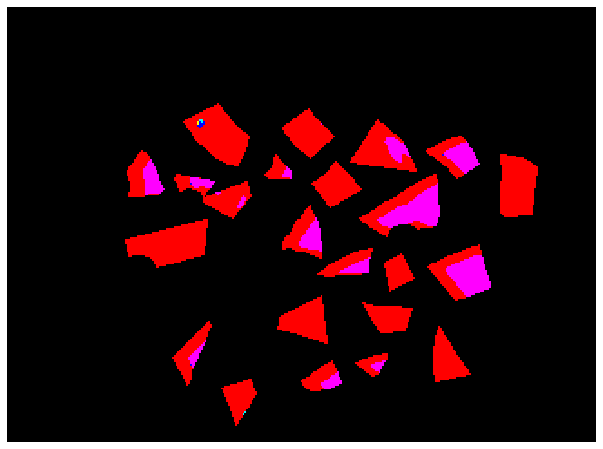

<Figure size 864x576 with 0 Axes>

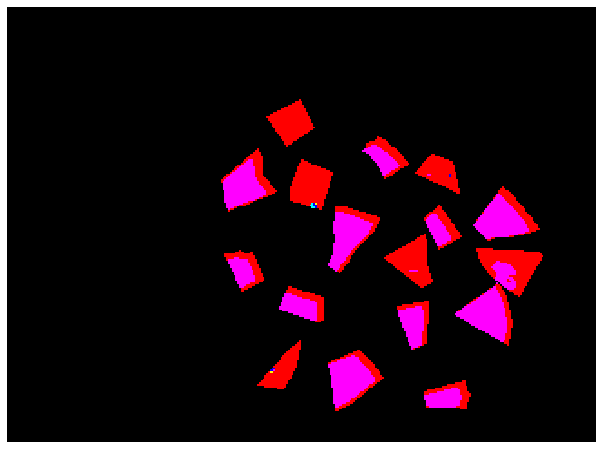

<Figure size 864x576 with 0 Axes>

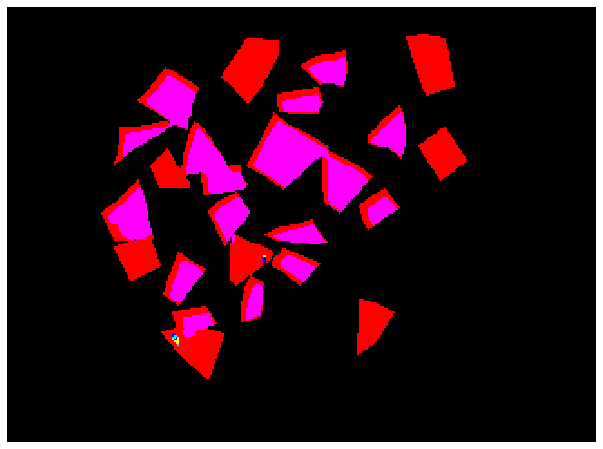

<Figure size 864x576 with 0 Axes>

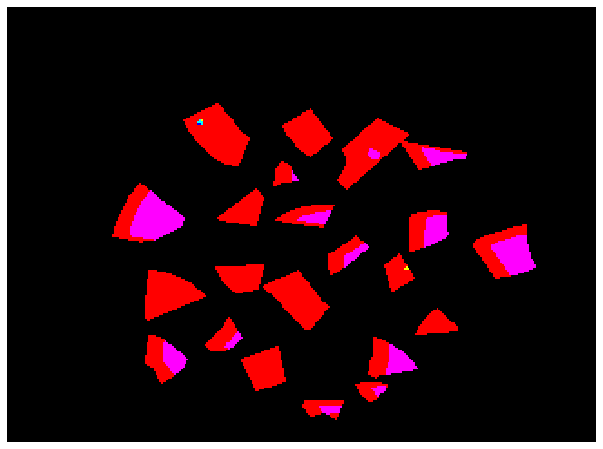

In [8]:
# SVM Pixel-wise Classification Results Visualization

import matplotlib.pyplot as plt

# test_indices = [0, 1, 4, 5, 6, 7, 8, 12, 41, 46, 50]
prediction_masks = reconstruct_predictions(test_GT, test_predictions2)
plt.figure(figsize=(12,8))
visualize_mask(prediction_masks[test_indices.index(0)])
plt.figure(figsize=(12,8))
visualize_mask(prediction_masks[test_indices.index(46)])
plt.figure(figsize=(12,8))
visualize_mask(prediction_masks[test_indices.index(41)])
plt.figure(figsize=(12,8))
visualize_mask(prediction_masks[test_indices.index(5)])


<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

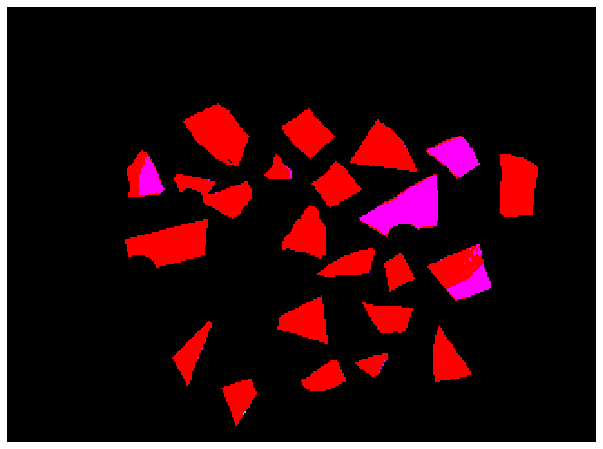

<Figure size 864x576 with 0 Axes>

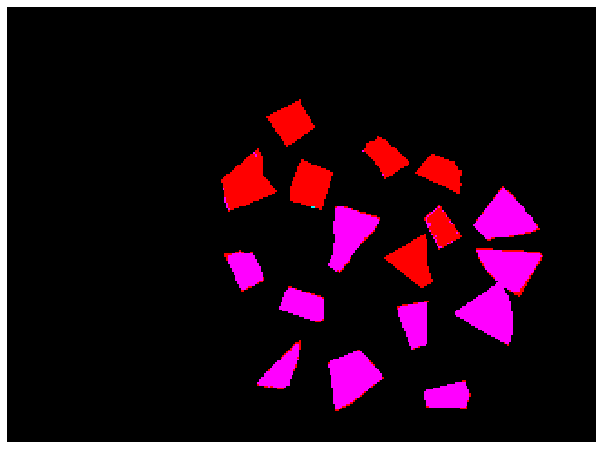

<Figure size 864x576 with 0 Axes>

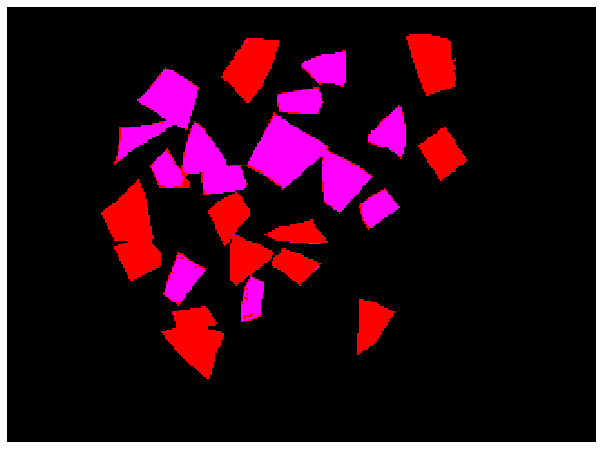

<Figure size 864x576 with 0 Axes>

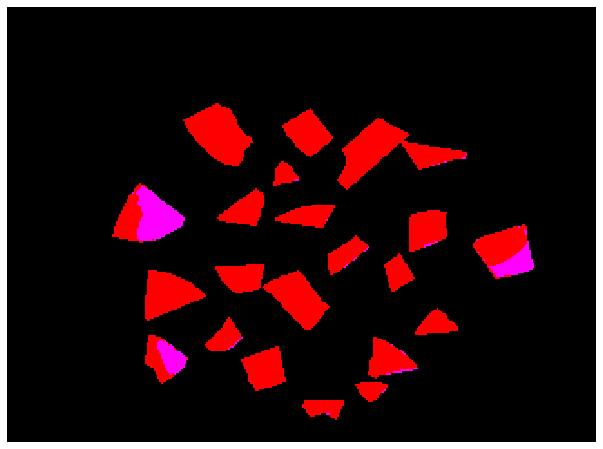

In [9]:
# Majority voting from zero-shot segmentation masks

objects = []
for i in test_indices:
    objects.append(load_and_decompress("zero-shot/" + str(i) +".pkl"))
    
# Apply with debugging
majority_voted_masks = majority_voting_with_segmentation(prediction_masks, objects, area = 10)

# Visualization (assuming your visualize_mask function works)
test_indices = [0, 1, 4, 5, 6, 7, 8, 12, 41, 46, 50]
plt.figure(figsize=(12,8))
for idx in [0, 46, 41, 5]:
    plt.figure(figsize=(12,8))
    visualize_mask(majority_voted_masks[test_indices.index(idx)])
plt.show()

In [10]:
# Random Forest Object-wise Classification Numerical Evaluation

metrics = calculate_segmentation_metrics(test_GT, majority_voted_masks)
print(f"Average F1-score: {metrics['average_f1_score']:.4f}")
print(f"F1-scores per class: {[f'{score:.4f}' for score in metrics['f1_scores_per_class']]}")
print(f"Average Accuracy (AA): {metrics['average_accuracy']:.4f}")
print(f"Kappa: {metrics['kappa']:.4f}")
print(f"Pixel Accuracy (OA): {metrics['pixel_accuracy']:.4f}")


Average F1-score: 0.4555
F1-scores per class: ['0.9992', '0.8159', '0.0124', '0.0481', '0.4017']
Average Accuracy (AA): 0.5477
Kappa: 0.7605
Pixel Accuracy (OA): 0.9631
